# **Product Recommendation**

Ampika Thanakaew ID: 6210422049

### **Initialize**

In [58]:
# -- coding: utf-8 --
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from scipy.spatial.distance import cosine
from sklearn.decomposition import NMF

%cd '/content/drive/MyDrive/BADS 7105 CRM/Product Recommendation/'
%ls

plt.rc('font', family='Angsana New')

/content/drive/MyDrive/BADS 7105 CRM/Product Recommendation
'Customer Preference Survey.csv'


In [73]:
import matplotlib as mpl
mpl.font_manager.fontManager.addfont('/content/drive/MyDrive/BADS 7105 CRM/font/Cordia New Bold.ttf')
mpl.rc('font', family='Cordia New', size=12, weight=200)

**Load Data**

In [59]:
df = pd.read_csv("Customer Preference Survey.csv")
df.head(5)

,ประทับเวลา,จักรยานเสือภูเขา,คอลลาเจน,Brownie อวกาศ,แม่โขง,Botox,กัญชา,กัญชง,เครื่องวัดความดัน,หลอดไฟเปลี่ยนสีได้,คอร์ส bikini wax,เก้าอี้นวดไฟฟ้า,ต้นไม้ประดับห้อง,หมอนข้าง,ตาชั่ง,คอร์สโบท็อกกราม,แสงโสม,กะหรี่(ปั๊บ),Lego,แฟน ที่แปลว่าพัดลม,ยาดอง,ชุดนอนไม่ได้นอน,ที่ยกน้ำหนัก (Dumbell),เครื่องดูดฝุ่นอัตโนมัติ (robot),เนื้อวากิล,หมูแดดเดียว,drone,เครื่องย่อยเศษอาหาร,เสื้อซีทรู,ไพ่ยิปซี,เนื้อย่าง,เครื่องทำลายเอกสาร,กระเป๋า,ชาบู,Surfskate,Board game,เครื่องย่อยเศษอาหาร.1,ชุดน้องหมา,Omakase,เม็ดมะม่วงหิมพานต์,ไฟอัจฉริยะ,บัตตาเลี่ยนที่ตัดผม,ไดร์เป่าผม Dyson,แผ่นเสียง,กรรไกรตัดขนจมูก,PS5,เครื่องตรวจน้ำตาลในเลือด,โรตี,กะปิดอง,น้องหมา,แพ็คเกจไทยเที่ยวไทย,เกมส์ FIFA Online,มะม่วงเบา,ห้องน้ำแมวอัตโนมัติ,กระเป๋า chanel,ข้าวขาหมูคากิคาจักออนไลน์,ถั่งเช่า,หมอนสุขภาพสำหรับคนนอนไม่หลับ,อาหารแมวคลีนเพื่อสุขภาพลดหุ่น,น้ำส้มดีโด้,Software ถูกลิขสิทธิ์,ครีมกันแดด,Unnamed: 62
0,2564/03/20 11:29:58 ก่อนเที่ยง GMT+7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,พริกทอด
1,2564/03/20 11:33:10 ก่อนเที่ยง GMT+7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,กล้วยทอด,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2564/03/20 11:53:44 ก่อนเที่ยง GMT+7,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,เคย,NaN
3,2564/03/20 11:54:00 ก่อนเที่ยง GMT+7,ไม่เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย,NaN
4,2564/03/20 11:54:05 ก่อนเที่ยง GMT+7,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,เคย,เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,เคย,NaN


**Data Cleansing**

In [60]:
# Remove 2 columns: Unnamed: 62, ประทับเวลา
df.drop(columns={'Unnamed: 62', 'ประทับเวลา'}, axis=1, inplace=True)
df.head(5)

,จักรยานเสือภูเขา,คอลลาเจน,Brownie อวกาศ,แม่โขง,Botox,กัญชา,กัญชง,เครื่องวัดความดัน,หลอดไฟเปลี่ยนสีได้,คอร์ส bikini wax,เก้าอี้นวดไฟฟ้า,ต้นไม้ประดับห้อง,หมอนข้าง,ตาชั่ง,คอร์สโบท็อกกราม,แสงโสม,กะหรี่(ปั๊บ),Lego,แฟน ที่แปลว่าพัดลม,ยาดอง,ชุดนอนไม่ได้นอน,ที่ยกน้ำหนัก (Dumbell),เครื่องดูดฝุ่นอัตโนมัติ (robot),เนื้อวากิล,หมูแดดเดียว,drone,เครื่องย่อยเศษอาหาร,เสื้อซีทรู,ไพ่ยิปซี,เนื้อย่าง,เครื่องทำลายเอกสาร,กระเป๋า,ชาบู,Surfskate,Board game,เครื่องย่อยเศษอาหาร.1,ชุดน้องหมา,Omakase,เม็ดมะม่วงหิมพานต์,ไฟอัจฉริยะ,บัตตาเลี่ยนที่ตัดผม,ไดร์เป่าผม Dyson,แผ่นเสียง,กรรไกรตัดขนจมูก,PS5,เครื่องตรวจน้ำตาลในเลือด,โรตี,กะปิดอง,น้องหมา,แพ็คเกจไทยเที่ยวไทย,เกมส์ FIFA Online,มะม่วงเบา,ห้องน้ำแมวอัตโนมัติ,กระเป๋า chanel,ข้าวขาหมูคากิคาจักออนไลน์,ถั่งเช่า,หมอนสุขภาพสำหรับคนนอนไม่หลับ,อาหารแมวคลีนเพื่อสุขภาพลดหุ่น,น้ำส้มดีโด้,Software ถูกลิขสิทธิ์,ครีมกันแดด
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,กล้วยทอด,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,เคย
3,ไม่เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย
4,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,เคย,เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,เคย


In [61]:
# Remove first 2 rows
df = df[2:]
df.head(5)

,จักรยานเสือภูเขา,คอลลาเจน,Brownie อวกาศ,แม่โขง,Botox,กัญชา,กัญชง,เครื่องวัดความดัน,หลอดไฟเปลี่ยนสีได้,คอร์ส bikini wax,เก้าอี้นวดไฟฟ้า,ต้นไม้ประดับห้อง,หมอนข้าง,ตาชั่ง,คอร์สโบท็อกกราม,แสงโสม,กะหรี่(ปั๊บ),Lego,แฟน ที่แปลว่าพัดลม,ยาดอง,ชุดนอนไม่ได้นอน,ที่ยกน้ำหนัก (Dumbell),เครื่องดูดฝุ่นอัตโนมัติ (robot),เนื้อวากิล,หมูแดดเดียว,drone,เครื่องย่อยเศษอาหาร,เสื้อซีทรู,ไพ่ยิปซี,เนื้อย่าง,เครื่องทำลายเอกสาร,กระเป๋า,ชาบู,Surfskate,Board game,เครื่องย่อยเศษอาหาร.1,ชุดน้องหมา,Omakase,เม็ดมะม่วงหิมพานต์,ไฟอัจฉริยะ,บัตตาเลี่ยนที่ตัดผม,ไดร์เป่าผม Dyson,แผ่นเสียง,กรรไกรตัดขนจมูก,PS5,เครื่องตรวจน้ำตาลในเลือด,โรตี,กะปิดอง,น้องหมา,แพ็คเกจไทยเที่ยวไทย,เกมส์ FIFA Online,มะม่วงเบา,ห้องน้ำแมวอัตโนมัติ,กระเป๋า chanel,ข้าวขาหมูคากิคาจักออนไลน์,ถั่งเช่า,หมอนสุขภาพสำหรับคนนอนไม่หลับ,อาหารแมวคลีนเพื่อสุขภาพลดหุ่น,น้ำส้มดีโด้,Software ถูกลิขสิทธิ์,ครีมกันแดด
2,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,เคย
3,ไม่เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย
4,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,เคย,เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,เคย
5,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,เคย,เคย,ไม่เคย,เคย,เคย,เคย,เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย
6,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,NaN,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,เคย


In [62]:
# check unique values, and NaN
df.melt()['value'].value_counts(dropna=False)

ไม่เคย    1710
เคย       1090
NaN          6
Name: value, dtype: int64

**Data Processing**

In [63]:
df.fillna('ไม่เคย', inplace=True)
df.replace({'เคย': 1, 'ไม่เคย': 0}, inplace=True)
df.head(5)

,จักรยานเสือภูเขา,คอลลาเจน,Brownie อวกาศ,แม่โขง,Botox,กัญชา,กัญชง,เครื่องวัดความดัน,หลอดไฟเปลี่ยนสีได้,คอร์ส bikini wax,เก้าอี้นวดไฟฟ้า,ต้นไม้ประดับห้อง,หมอนข้าง,ตาชั่ง,คอร์สโบท็อกกราม,แสงโสม,กะหรี่(ปั๊บ),Lego,แฟน ที่แปลว่าพัดลม,ยาดอง,ชุดนอนไม่ได้นอน,ที่ยกน้ำหนัก (Dumbell),เครื่องดูดฝุ่นอัตโนมัติ (robot),เนื้อวากิล,หมูแดดเดียว,drone,เครื่องย่อยเศษอาหาร,เสื้อซีทรู,ไพ่ยิปซี,เนื้อย่าง,เครื่องทำลายเอกสาร,กระเป๋า,ชาบู,Surfskate,Board game,เครื่องย่อยเศษอาหาร.1,ชุดน้องหมา,Omakase,เม็ดมะม่วงหิมพานต์,ไฟอัจฉริยะ,บัตตาเลี่ยนที่ตัดผม,ไดร์เป่าผม Dyson,แผ่นเสียง,กรรไกรตัดขนจมูก,PS5,เครื่องตรวจน้ำตาลในเลือด,โรตี,กะปิดอง,น้องหมา,แพ็คเกจไทยเที่ยวไทย,เกมส์ FIFA Online,มะม่วงเบา,ห้องน้ำแมวอัตโนมัติ,กระเป๋า chanel,ข้าวขาหมูคากิคาจักออนไลน์,ถั่งเช่า,หมอนสุขภาพสำหรับคนนอนไม่หลับ,อาหารแมวคลีนเพื่อสุขภาพลดหุ่น,น้ำส้มดีโด้,Software ถูกลิขสิทธิ์,ครีมกันแดด
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,0,0,0,1,1,1,0,0,0,0,1,0,1,1,0,1,0,0,1,1,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1
3,0,1,0,1,0,0,0,1,0,0,0,0,1,1,0,1,1,0,1,0,1,1,1,0,1,0,0,1,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,1,1,1,0,1,0,1,0,0,0,1,1,0,1,0,1
4,1,0,0,0,0,0,0,1,1,0,0,1,1,1,0,0,1,1,1,0,1,1,0,1,1,1,0,1,0,1,1,1,1,1,1,0,1,0,1,1,1,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,1,0,1,1,1
5,0,0,0,1,0,1,0,0,0,0,1,1,1,1,0,1,1,1,1,1,0,0,1,1,1,0,0,0,0,1,0,1,1,0,1,0,0,1,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1
6,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,1,1,0,1,0,0,0,1,0,0,1,1,0,1,0,1,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,1,1,1


In [64]:
df[['เครื่องย่อยเศษอาหาร', 'เครื่องย่อยเศษอาหาร.1']].corr()

,เครื่องย่อยเศษอาหาร,เครื่องย่อยเศษอาหาร.1
เครื่องย่อยเศษอาหาร,1.0,1.0
เครื่องย่อยเศษอาหาร.1,1.0,1.0


In [65]:
df.drop('เครื่องย่อยเศษอาหาร.1', axis=1, inplace=True)

In [66]:
df.rename({'เนื้อวากิล':'เนื้อวากิว'}, axis=1, inplace=True)

**EDA**

In [67]:
df.describe().T.sort_values('mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
ครีมกันแดด,46.0,1.000000,0.000000,1.0,1.0,1.0,1.00,1.0
กระเป๋า,46.0,1.000000,0.000000,1.0,1.0,1.0,1.00,1.0
ชาบู,46.0,1.000000,0.000000,1.0,1.0,1.0,1.00,1.0
โรตี,46.0,0.956522,0.206185,0.0,1.0,1.0,1.00,1.0
กะหรี่(ปั๊บ),46.0,0.934783,0.249637,0.0,1.0,1.0,1.00,1.0
เม็ดมะม่วงหิมพานต์,46.0,0.913043,0.284885,0.0,1.0,1.0,1.00,1.0
หมอนข้าง,46.0,0.869565,0.340503,0.0,1.0,1.0,1.00,1.0
หมูแดดเดียว,46.0,0.804348,0.401085,0.0,1.0,1.0,1.00,1.0
แฟน ที่แปลว่าพัดลม,46.0,0.804348,0.401085,0.0,1.0,1.0,1.00,1.0
Software ถูกลิขสิทธิ์,46.0,0.782609,0.417029,0.0,1.0,1.0,1.00,1.0


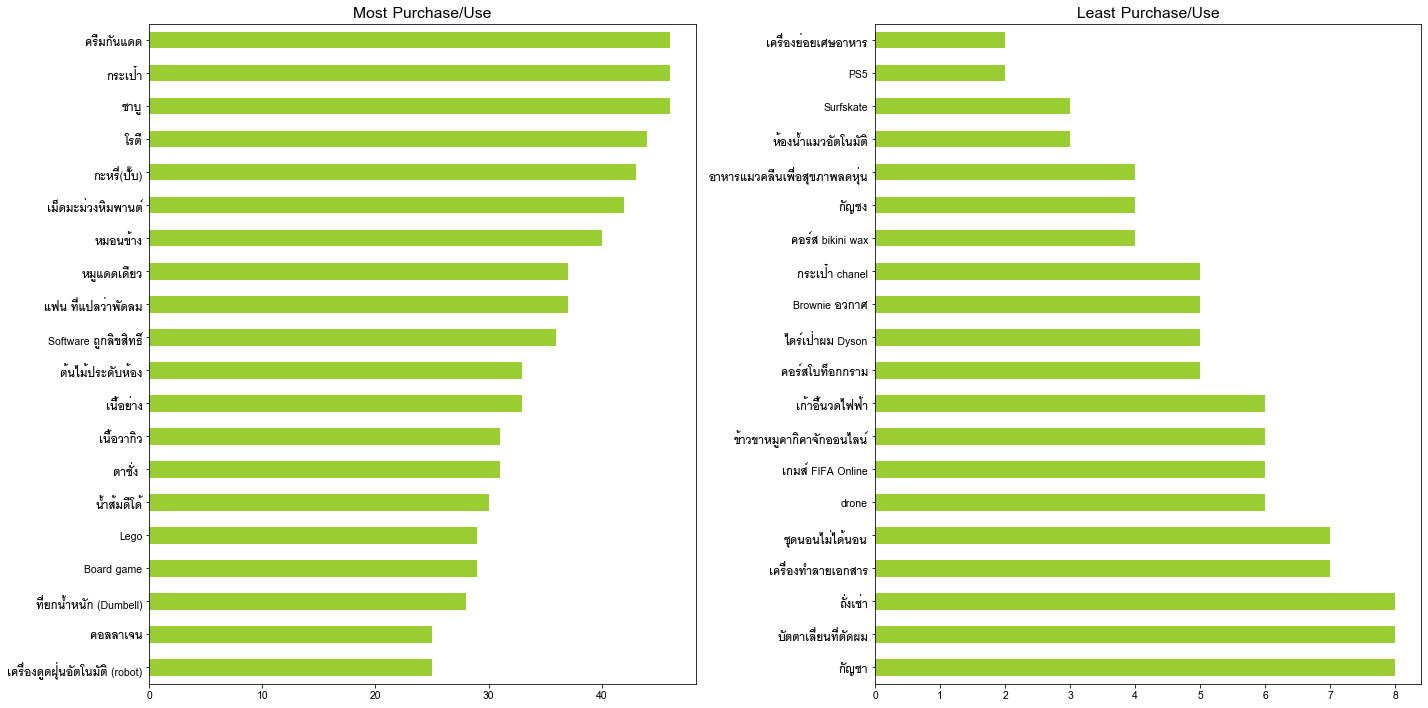

In [75]:
total_purchase_per_item = (
    df
    .sum()
    .sort_values(ascending=False)
    .to_frame()
    .rename({0: 'count'}, axis=1)
)
most_purchase_items = total_purchase_per_item[:20]
least_purchase_items = total_purchase_per_item[-20:]

fig, axes = plt.subplots(1, 2, figsize=(20, 10), tight_layout=True)
most_purchase_items.sort_values('count', ascending=True).plot.barh(ax=axes[0], title='Most Purchase/Use', legend=False, color='yellowgreen')
least_purchase_items.plot.barh(ax=axes[1], title='Least Purchase/Use', legend=False, color='yellowgreen')
plt.rc('axes', titlesize=24)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.show()

## **Frequent Itemsets & Association Rules**

In [76]:
frequent_itemsets = apriori(df, min_support=0.5, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])
rules["antecedent_len"] = rules["antecedents"].apply(lambda x: len(x))
rules["consequents_len"] = rules["consequents"].apply(lambda x: len(x))
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len,consequents_len
106798,"(เนื้อย่าง, ตาชั่ง , เม็ดมะม่วงหิมพานต์)","(กะหรี่(ปั๊บ), แฟน ที่แปลว่าพัดลม, โรตี)",0.5,0.76087,0.5,1.0,1.314286,0.119565,inf,3,3
210811,"(เนื้อย่าง, ตาชั่ง , กระเป๋า, เม็ดมะม่วงหิมพานต์)","(กะหรี่(ปั๊บ), แฟน ที่แปลว่าพัดลม, โรตี)",0.5,0.76087,0.5,1.0,1.314286,0.119565,inf,4,3
210844,"(เนื้อย่าง, ตาชั่ง , เม็ดมะม่วงหิมพานต์)","(กะหรี่(ปั๊บ), แฟน ที่แปลว่าพัดลม, โรตี, กระเป๋า)",0.5,0.76087,0.5,1.0,1.314286,0.119565,inf,3,4
211189,"(เนื้อย่าง, ตาชั่ง , เม็ดมะม่วงหิมพานต์, ชาบู)","(กะหรี่(ปั๊บ), แฟน ที่แปลว่าพัดลม, โรตี)",0.5,0.76087,0.5,1.0,1.314286,0.119565,inf,4,3
211222,"(เนื้อย่าง, ตาชั่ง , เม็ดมะม่วงหิมพานต์)","(กะหรี่(ปั๊บ), แฟน ที่แปลว่าพัดลม, โรตี, ชาบู)",0.5,0.76087,0.5,1.0,1.314286,0.119565,inf,3,4
...,...,...,...,...,...,...,...,...,...,...,...
383741,"(ครีมกันแดด, ชาบู)","(โรตี, หมูแดดเดียว, แฟน ที่แปลว่าพัดลม, เม็ดมะ...",1.0,0.50000,0.5,0.5,1.000000,0.000000,1.0,2,8
383771,"(กระเป๋า, ชาบู)","(ครีมกันแดด, โรตี, หมูแดดเดียว, แฟน ที่แปลว่าพ...",1.0,0.50000,0.5,0.5,1.000000,0.000000,1.0,2,8
383780,(ครีมกันแดด),"(โรตี, หมูแดดเดียว, แฟน ที่แปลว่าพัดลม, เม็ดมะ...",1.0,0.50000,0.5,0.5,1.000000,0.000000,1.0,1,9
383785,(กระเป๋า),"(ครีมกันแดด, โรตี, หมูแดดเดียว, แฟน ที่แปลว่าพ...",1.0,0.50000,0.5,0.5,1.000000,0.000000,1.0,1,9


**Antecedents and Consequents is 1 itemsets**

In [77]:
one_item_rule = rules[ 
    (rules['antecedent_len'] == 1) &
    (rules['consequents_len'] == 1) &
    (rules['confidence'] > 0.5) &
    (rules['lift'] > 1.05) 
]
one_item_rule["antecedents"] = one_item_rule["antecedents"].apply(lambda x: list(x)[0]).astype("unicode")
one_item_rule["consequents"] = one_item_rule["consequents"].apply(lambda x: list(x)[0]).astype("unicode")
one_item_rule = one_item_rule.sort_values('lift', ascending=False)
one_item_rule

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len,consequents_len
161,เนื้อวากิว,เนื้อย่าง,0.673913,0.717391,0.652174,0.967742,1.348974,0.168715,8.760870,1,1
160,เนื้อย่าง,เนื้อวากิว,0.717391,0.673913,0.652174,0.909091,1.348974,0.168715,3.586957,1,1
19,Lego,ต้นไม้ประดับห้อง,0.630435,0.717391,0.543478,0.862069,1.201672,0.091210,2.048913,1,1
18,ต้นไม้ประดับห้อง,Lego,0.717391,0.630435,0.543478,0.757576,1.201672,0.091210,1.524457,1,1
100,เนื้อย่าง,Lego,0.717391,0.630435,0.521739,0.727273,1.153605,0.069471,1.355072,1,1
101,Lego,เนื้อย่าง,0.630435,0.717391,0.521739,0.827586,1.153605,0.069471,1.639130,1,1
158,หมูแดดเดียว,เนื้อวากิว,0.804348,0.673913,0.608696,0.756757,1.122929,0.066635,1.340580,1,1
159,เนื้อวากิว,หมูแดดเดียว,0.673913,0.804348,0.608696,0.903226,1.122929,0.066635,2.021739,1,1
171,เนื้อวากิว,Software ถูกลิขสิทธิ์,0.673913,0.782609,0.586957,0.870968,1.112903,0.059546,1.684783,1,1
170,Software ถูกลิขสิทธิ์,เนื้อวากิว,0.782609,0.673913,0.586957,0.750000,1.112903,0.059546,1.304348,1,1


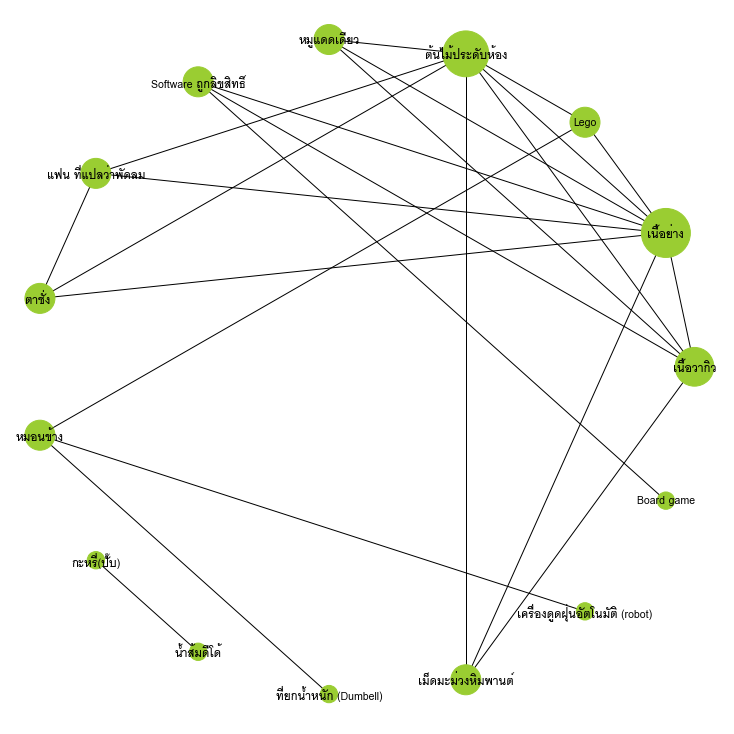

In [79]:
G = nx.from_pandas_edgelist(one_item_rule, source='antecedents', target='consequents', edge_attr='lift')
d = dict(G.degree)
nx.draw_circular(
    G, 
    node_size=[d[k] * 300 for k in dict(G.degree)], 
    with_labels=True, 
    font_family='Cordia New', 
    font_size='16',
    node_color='yellowgreen'
) 
plt.rcParams["figure.figsize"] = (10, 10)
plt.show()

**Antecedents and Consequents is 2 itemsets**

In [80]:
two_items_rule = rules[ 
    (rules['antecedent_len'] == 2) &
    (rules['consequents_len'] == 2) &
    (rules['confidence'] > 0.9) &
    (rules['lift'] > 1.35) 
]
two_items_rule["antecedents"] = two_items_rule["antecedents"].apply(lambda x: list(x)).astype("unicode")
two_items_rule["consequents"] = two_items_rule["consequents"].apply(lambda x: list(x)).astype("unicode")
two_items_rule = two_items_rule.sort_values('lift', ascending=False)
two_items_rule

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len,consequents_len
14472,"['เนื้อย่าง', 'หมูแดดเดียว']","['เนื้อวากิว', 'เม็ดมะม่วงหิมพานต์']",0.630435,0.652174,0.586957,0.931034,1.427586,0.175803,5.043478,2,2
14475,"['หมูแดดเดียว', 'เนื้อวากิว']","['เนื้อย่าง', 'เม็ดมะม่วงหิมพานต์']",0.608696,0.695652,0.586957,0.964286,1.386161,0.163516,8.521739,2,2
10071,"['แฟน ที่แปลว่าพัดลม', 'เนื้อวากิว']","['เนื้อย่าง', 'กะหรี่(ปั๊บ)']",0.565217,0.695652,0.543478,0.961538,1.382212,0.150284,7.913043,2,2
12879,"['แฟน ที่แปลว่าพัดลม', 'เนื้อวากิว']","['เนื้อย่าง', 'เม็ดมะม่วงหิมพานต์']",0.565217,0.695652,0.543478,0.961538,1.382212,0.150284,7.913043,2,2
14444,"['เนื้อย่าง', 'หมูแดดเดียว']","['กระเป๋า', 'เนื้อวากิว']",0.630435,0.673913,0.586957,0.931034,1.381535,0.162098,4.728261,2,2
14458,"['เนื้อย่าง', 'หมูแดดเดียว']","['เนื้อวากิว', 'ชาบู']",0.630435,0.673913,0.586957,0.931034,1.381535,0.162098,4.728261,2,2
14486,"['เนื้อย่าง', 'หมูแดดเดียว']","['โรตี', 'เนื้อวากิว']",0.630435,0.673913,0.586957,0.931034,1.381535,0.162098,4.728261,2,2
14518,"['เนื้อย่าง', 'หมูแดดเดียว']","['ครีมกันแดด', 'เนื้อวากิว']",0.630435,0.673913,0.586957,0.931034,1.381535,0.162098,4.728261,2,2
14782,"['Software ถูกลิขสิทธิ์', 'เนื้อย่าง']","['กระเป๋า', 'เนื้อวากิว']",0.608696,0.673913,0.565217,0.928571,1.377880,0.155009,4.565217,2,2
14838,"['Software ถูกลิขสิทธิ์', 'เนื้อย่าง']","['เนื้อวากิว', 'ชาบู']",0.608696,0.673913,0.565217,0.928571,1.377880,0.155009,4.565217,2,2


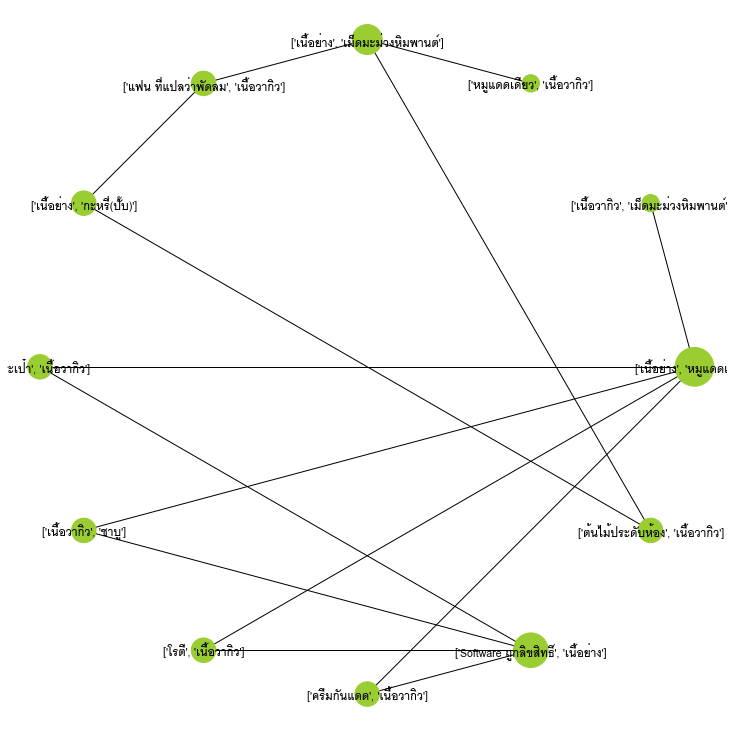

In [81]:
G = nx.from_pandas_edgelist(two_items_rule, source='antecedents', target='consequents')
d = dict(G.degree)
nx.draw_circular(
    G, 
    node_size=[d[k] * 300 for k in dict(G.degree)], 
    with_labels=True, 
    font_family='Cordia New', 
    font_size='16',
    node_color='yellowgreen'
) 
plt.rcParams["figure.figsize"] = (10, 10)
plt.show()

## **Collaborative Filtering Model**

In [90]:
cosine_df = pd.DataFrame(index=df.columns,columns=df.columns)
for i in range(0,len(cosine_df.columns)) :
    for j in range(0,len(cosine_df.columns)) :
      cosine_df.iloc[i, j] = 1 - cosine(df.iloc[: , i], df.iloc[: , j])
cosine_df.head(5)

,จักรยานเสือภูเขา,คอลลาเจน,Brownie อวกาศ,แม่โขง,Botox,กัญชา,กัญชง,เครื่องวัดความดัน,หลอดไฟเปลี่ยนสีได้,คอร์ส bikini wax,เก้าอี้นวดไฟฟ้า,ต้นไม้ประดับห้อง,หมอนข้าง,ตาชั่ง,คอร์สโบท็อกกราม,แสงโสม,กะหรี่(ปั๊บ),Lego,แฟน ที่แปลว่าพัดลม,ยาดอง,ชุดนอนไม่ได้นอน,ที่ยกน้ำหนัก (Dumbell),เครื่องดูดฝุ่นอัตโนมัติ (robot),เนื้อวากิว,หมูแดดเดียว,drone,เครื่องย่อยเศษอาหาร,เสื้อซีทรู,ไพ่ยิปซี,เนื้อย่าง,เครื่องทำลายเอกสาร,กระเป๋า,ชาบู,Surfskate,Board game,ชุดน้องหมา,Omakase,เม็ดมะม่วงหิมพานต์,ไฟอัจฉริยะ,บัตตาเลี่ยนที่ตัดผม,ไดร์เป่าผม Dyson,แผ่นเสียง,กรรไกรตัดขนจมูก,PS5,เครื่องตรวจน้ำตาลในเลือด,โรตี,กะปิดอง,น้องหมา,แพ็คเกจไทยเที่ยวไทย,เกมส์ FIFA Online,มะม่วงเบา,ห้องน้ำแมวอัตโนมัติ,กระเป๋า chanel,ข้าวขาหมูคากิคาจักออนไลน์,ถั่งเช่า,หมอนสุขภาพสำหรับคนนอนไม่หลับ,อาหารแมวคลีนเพื่อสุขภาพลดหุ่น,น้ำส้มดีโด้,Software ถูกลิขสิทธิ์,ครีมกันแดด
จักรยานเสือภูเขา,1,0.55,0.33541,0.400892,0.416667,0.265165,0.25,0.458831,0.452267,0.125,0.102062,0.522233,0.592927,0.583717,0.223607,0.375,0.533745,0.60351,0.534297,0.216506,0.188982,0.661438,0.55,0.538816,0.452097,0.306186,0.353553,0.376889,0.301511,0.565752,0.472456,0.589768,0.589768,0.433013,0.417815,0.375,0.395285,0.540062,0.580948,0.265165,0.33541,0.416667,0.53033,0.176777,0.474342,0.603023,0.416667,0.395285,0.381881,0.102062,0.471405,0.433013,0.33541,0.306186,0.0883883,0.471405,0.375,0.456435,0.583333,0.589768
คอลลาเจน,0.55,1,0.268328,0.320713,0.533333,0.141421,0.2,0.458831,0.361814,0.4,0.163299,0.661495,0.664078,0.610658,0.447214,0.3,0.731993,0.705642,0.624716,0.404145,0.377964,0.680336,0.6,0.538816,0.624716,0.326599,0.282843,0.603023,0.482418,0.591864,0.377964,0.73721,0.73721,0.23094,0.482808,0.6,0.316228,0.709795,0.464758,0.353553,0.357771,0.333333,0.518545,0.141421,0.442719,0.753778,0.466667,0.505964,0.523723,0.244949,0.565685,0.34641,0.357771,0.244949,0.282843,0.612826,0.4,0.657267,0.7,0.73721
Brownie อวกาศ,0.33541,0.268328,1,0.478091,0.447214,0.632456,0.67082,0.102598,0.13484,0.223607,0.365148,0.389249,0.282843,0.321288,0.2,0.33541,0.340997,0.415227,0.367607,0.258199,0.169031,0.338062,0.357771,0.40161,0.294086,0.365148,0.316228,0.13484,0.26968,0.3114,0.169031,0.32969,0.32969,0.258199,0.249136,0.111803,0.424264,0.345033,0.34641,0.316228,0.2,0.596285,0.210819,0.316228,0.282843,0.3371,0.298142,0.141421,0.29277,0.365148,0.210819,0.516398,0.8,0.547723,0.158114,0.316228,0.447214,0.244949,0.372678,0.32969
แม่โขง,0.400892,0.320713,0.478091,1,0.267261,0.566947,0.400892,0.367884,0.241747,0.133631,0.436436,0.558291,0.507093,0.432014,0.119523,0.868599,0.570597,0.397033,0.52725,0.308607,0.303046,0.454569,0.427618,0.576018,0.571187,0.327327,0.188982,0.241747,0.402911,0.511766,0.202031,0.551677,0.551677,0.154303,0.397033,0.0668153,0.507093,0.57735,0.276026,0.283473,0.239046,0.445435,0.566947,0.188982,0.169031,0.564076,0.356348,0,0.349927,0.327327,0.377964,0.46291,0.358569,0.218218,0.188982,0.440959,0.267261,0.39036,0.400892,0.551677
Botox,0.416667,0.533333,0.447214,0.267261,1,0.235702,0.333333,0.229416,0.301511,0.166667,0.136083,0.348155,0.368932,0.299342,0.745356,0.25,0.406663,0.309492,0.493197,0.288675,0.377964,0.503953,0.333333,0.359211,0.328798,0.136083,0.235702,0.402015,0.402015,0.348155,0.251976,0.442326,0.442326,0.19245,0.185695,0.333333,0.316228,0.411476,0.258199,0.235702,0.298142,0.333333,0.31427,0.235702,0.421637,0.452267,0.333333,0.316228,0.363696,0.136083,0.235702,0.19245,0.596285,0.408248,0.117851,0.392837,0.166667,0.30429,0.5,0.442326


In [93]:
item_item_cosine_df = (
    cosine_df
    .stack()
    .reset_index()
    .rename(columns={'level_0': 'item_1', 'level_1': 'item_2', 0: 'sim'})
)
# item_item_cosine_df
item_item_cosine_df.sort_values('sim', ascending=False)

,item_1,item_2,sim
0,จักรยานเสือภูเขา,จักรยานเสือภูเขา,1
122,Brownie อวกาศ,Brownie อวกาศ,1
1892,กระเป๋า,ชาบู,1
1891,กระเป๋า,กระเป๋า,1
1830,เครื่องทำลายเอกสาร,เครื่องทำลายเอกสาร,1
...,...,...,...
2630,PS5,มะม่วงเบา,0
2629,PS5,เกมส์ FIFA Online,0
2628,PS5,แพ็คเกจไทยเที่ยวไทย,0
2627,PS5,น้องหมา,0


In [94]:
item_item_cosine_df = item_item_cosine_df.loc[(item_item_cosine_df['sim'] > 0.6) & (item_item_cosine_df['item_1'] != item_item_cosine_df['item_2'])]
item_item_cosine_df.sort_values('sim', ascending=False)

,item_1,item_2,sim
1919,กระเป๋า,ครีมกันแดด,1
3572,ครีมกันแดด,ชาบู,1
1979,ชาบู,ครีมกันแดด,1
1892,กระเป๋า,ชาบู,1
3571,ครีมกันแดด,กระเป๋า,1
...,...,...,...
45,จักรยานเสือภูเขา,โรตี,0.603023
457,เครื่องวัดความดัน,เม็ดมะม่วงหิมพานต์,0.601793
2227,เม็ดมะม่วงหิมพานต์,เครื่องวัดความดัน,0.601793
82,คอลลาเจน,เครื่องดูดฝุ่นอัตโนมัติ (robot),0.6


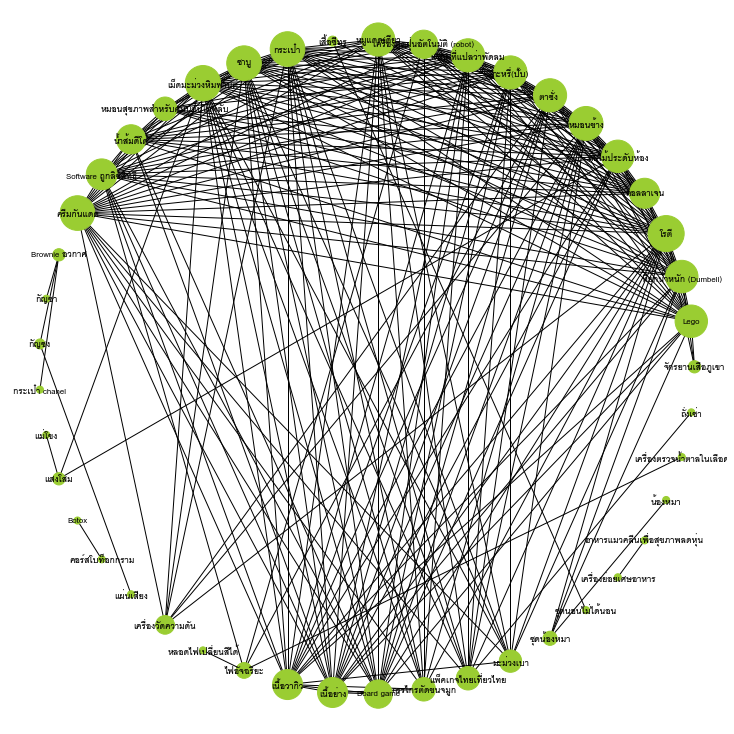

In [96]:
G = nx.from_pandas_edgelist(item_item_cosine_df, source='item_1', target='item_2', edge_attr='sim')
d = dict(G.degree)
nx.draw_circular(
    G, 
    node_size=[d[k] * 50 for k in dict(G.degree)], 
    with_labels=True, 
    font_family='Cordia New', 
    font_size='12',
    node_color='yellowgreen'
) 
plt.rcParams["figure.figsize"] = (10, 10)
plt.show()

## **Matrix Factorization**

**Non-Matrix Factorization**

In [109]:
for n in range(2, 20):
    nmf = NMF(n_components=n, random_state=48)
    nmf.fit_transform(df)
    print(f'Reconstruction error: {nmf.reconstruction_err_}')

nmf = NMF(n_components=20, random_state=48, max_iter=1000)
W = nmf.fit_transform(df)
H = nmf.components_
nR = np.dot(W,H)
nmf_df = pd.DataFrame(nR, columns=df.columns, index=df.index)
nmf_df.head()

Reconstruction error: 18.855843698161145
Reconstruction error: 17.97941833673208
Reconstruction error: 17.19533736720318
Reconstruction error: 16.476217643514477
Reconstruction error: 15.871965768742212
Reconstruction error: 15.3386337715486
Reconstruction error: 14.854515734071818
Reconstruction error: 14.390589214650987
Reconstruction error: 13.989479072913161
Reconstruction error: 13.568115323794876
Reconstruction error: 13.225018946930621
Reconstruction error: 12.80005554764761
Reconstruction error: 12.352458898383416
Reconstruction error: 11.99342057876806
Reconstruction error: 11.635543135117615
Reconstruction error: 11.430008621966794
Reconstruction error: 10.98223058230397
Reconstruction error: 10.63634765761798


,จักรยานเสือภูเขา,คอลลาเจน,Brownie อวกาศ,แม่โขง,Botox,กัญชา,กัญชง,เครื่องวัดความดัน,หลอดไฟเปลี่ยนสีได้,คอร์ส bikini wax,เก้าอี้นวดไฟฟ้า,ต้นไม้ประดับห้อง,หมอนข้าง,ตาชั่ง,คอร์สโบท็อกกราม,แสงโสม,กะหรี่(ปั๊บ),Lego,แฟน ที่แปลว่าพัดลม,ยาดอง,ชุดนอนไม่ได้นอน,ที่ยกน้ำหนัก (Dumbell),เครื่องดูดฝุ่นอัตโนมัติ (robot),เนื้อวากิว,หมูแดดเดียว,drone,เครื่องย่อยเศษอาหาร,เสื้อซีทรู,ไพ่ยิปซี,เนื้อย่าง,เครื่องทำลายเอกสาร,กระเป๋า,ชาบู,Surfskate,Board game,ชุดน้องหมา,Omakase,เม็ดมะม่วงหิมพานต์,ไฟอัจฉริยะ,บัตตาเลี่ยนที่ตัดผม,ไดร์เป่าผม Dyson,แผ่นเสียง,กรรไกรตัดขนจมูก,PS5,เครื่องตรวจน้ำตาลในเลือด,โรตี,กะปิดอง,น้องหมา,แพ็คเกจไทยเที่ยวไทย,เกมส์ FIFA Online,มะม่วงเบา,ห้องน้ำแมวอัตโนมัติ,กระเป๋า chanel,ข้าวขาหมูคากิคาจักออนไลน์,ถั่งเช่า,หมอนสุขภาพสำหรับคนนอนไม่หลับ,อาหารแมวคลีนเพื่อสุขภาพลดหุ่น,น้ำส้มดีโด้,Software ถูกลิขสิทธิ์,ครีมกันแดด
2,0.375487,0.150371,0.040518,0.035778,0.065884,0.083601,0.054949,0.001024,0.010107,0.058490,0.043966,0.041108,0.667874,0.350794,0.049600,1.646290e-07,1.013719,0.867051,0.860132,0.029726,0.013936,0.173952,1.119659,1.069995,0.938364,0.045128,0.000000,0.206007,0.007231,1.248260,0.004536,0.993183,0.993183,0.003893,0.988234,0.012945,0.895372,0.789721,0.036414,0.024388,0.076863,0.195588,1.014813,0.224027,0.001019,1.045668,0.005530,0.001214,0.090892,0.062490,0.086737,0.001303,0.013340,0.038319,0.078679,0.025666,0.004731,1.085682,0.780646,0.993183
3,0.389006,0.725611,0.021851,0.928399,0.054954,0.108229,0.007314,0.705313,0.052720,0.258343,0.046608,0.360729,0.965495,0.938318,0.067131,9.065451e-01,1.095181,0.120890,0.807764,0.000000,0.879980,1.029789,0.847943,0.392301,0.911194,0.177394,0.025498,0.929840,1.029009,0.317312,0.083960,1.137720,1.137720,0.020650,0.384920,0.176678,0.213758,1.125111,0.223118,0.010816,0.081150,0.210749,0.663958,0.047004,0.788677,0.898669,0.494696,0.311496,1.017041,0.000000,1.162315,0.184252,0.000000,0.156601,0.979194,0.954786,0.000000,0.787369,0.002346,1.137720
4,1.013169,0.320841,0.059057,0.000000,0.002897,0.024929,0.013524,0.647816,0.945500,0.145621,0.465455,0.927862,1.025744,1.217621,0.067801,1.070275e-01,1.020674,0.652030,1.042868,0.123232,0.717217,1.142692,0.147453,1.023792,0.918440,0.515718,0.095200,1.080368,0.000495,0.851667,0.755165,0.964809,0.964809,0.512470,0.993936,1.193730,0.038571,0.977668,0.978667,1.057366,0.090563,0.229586,0.327607,0.013336,0.896625,0.985001,0.437998,0.927560,0.061242,0.150577,1.079973,0.063934,0.000000,0.097243,0.000000,0.908205,0.302041,0.837517,1.230472,0.964809
5,0.289371,0.009875,0.060526,0.792907,0.000000,0.632173,0.083950,0.675773,0.018371,0.004987,0.659063,1.003498,1.186723,0.810748,0.000997,1.014402e+00,0.921159,0.944916,1.086950,0.864727,0.085783,0.122597,0.985290,0.885254,0.924165,0.418219,0.000000,0.013197,0.015306,0.977102,0.179628,1.003401,1.003401,0.250690,0.882538,0.058067,0.799301,1.140621,0.035679,0.901514,0.035888,0.087248,1.141359,0.137007,0.040832,0.924642,0.000000,0.040599,0.442653,0.650979,0.080188,0.072393,0.003688,0.005228,0.000463,0.037932,0.189554,0.233663,0.170687,1.003401
6,0.091097,0.986241,0.084342,0.024536,0.955114,0.004905,0.000055,0.023656,0.138378,0.121334,0.014456,0.625566,0.510473,0.137173,0.796712,5.697409e-02,1.026757,0.127256,1.029088,0.014440,0.058753,1.045308,1.109433,0.037034,0.744677,0.170016,0.195433,0.253307,0.632470,0.112060,0.461148,1.038045,1.038045,0.015025,0.983308,1.128029,0.055137,0.976936,0.084268,0.027201,0.457728,0.123412,0.103741,0.034990,0.060595,1.036083,0.087142,1.206455,0.098304,0.067045,0.003318,0.000358,0.475209,0.062363,0.040700,0.901784,0.142236,0.980301,0.940042,1.038045


**Recommend items to users**

In [110]:
def get_recommend_items(row):
    recommend_df = row.sort_values(ascending=False).head(3).to_frame().reset_index()
    recommend_df.columns = ['item', 'value']
    recommend_items = recommend_df['item']
    recommend_value = recommend_df['value']
    return (", ".join([item + " " + str(value) for item, value in zip(recommend_items.values, recommend_value.values)]))

nmf_df['recommend'] = nmf_df.apply(lambda row: get_recommend_items(row), axis=1)

In [111]:
(
    nmf_df
    .reset_index()
    .rename(columns={'index': 'user'})
)[['user', 'recommend']].head()

,user,recommend
0,2,"เนื้อย่าง 1.2482595444718256, เครื่องดูดฝุ่นอั..."
1,3,"มะม่วงเบา 1.1623148279764663, ครีมกันแดด 1.137..."
2,4,"Software ถูกลิขสิทธิ์ 1.2304720378980576, ตาชั..."
3,5,"หมอนข้าง 1.18672320007378, กรรไกรตัดขนจมูก 1.1..."
4,6,"น้องหมา 1.2064549321053872, ชุดน้องหมา 1.12802..."
